# **Use Case 1:** Racial Bias in Dermatological Image Classification: subgroup representation matters

- Fairness & Medical Imaging Tutorial at MICCAI 2025 (South Korea)
- **Lecturer:** Miguel López-Pérez (mlopez@decsai.ugr.es)


In this notebook, we will explore an **end-to-end example of racial bias in dermatological image classification**. We will utilize the *Fitzpatrick17k* dataset, which contains over 17,000 dermatology images labeled with corresponding skin tones and skin condition. This publicly available dataset is a valuable resource for investigating potential racial bias in medical image classification tasks. The reference for this dataset is:

- Groh, M., Harris, C., Soenksen, L., Lau, F., Han, R., Kim, A., ... & Badri, O. (2021). *Evaluating deep neural networks trained on clinical images in dermatology with the fitzpatrick 17k dataset.* In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 1820-1828).

The images in the dataset are sourced from two different dermatological atlases. So, they have not been standardized for use in machine learning models. Instead, they reflect how dermatologists typically view skin conditions in real-world clinical settings, making the dataset particularly suitable for studying bias in a realistic context.

We will begin with data exploration to understand the distribution of images across different skin tones and skin conditions. Following that, we will define and train a convolutional neural network (CNN) using PyTorch. Finally, we will evaluate the model and analyze how different training configurations affect its predictive performance across two racial groups. This will help us assess whether and how racial bias manifests in the model’s behavior.



## Mount drive
We will access the dataset online, as it is stored in a shared Google Drive directory. To begin, we need to mount Google Drive within our Google Colab environment. This step allows us to establish a connection between Colab and the Drive account that contains the data. Once the drive is successfully mounted, we can navigate to the specified directory path to locate the required files. These include a folder containing the dermatology images and a corresponding dataframe (usually in CSV format) that holds the labels or metadata associated with each image, such as the diagnosis, skin tone category, or other relevant attributes.

**https://drive.google.com/drive/folders/1XeT0gGrPmg3KATfm3n7Qh5NDkUCsDwmv?usp=drive_link to request an invitation to the directory where the data is hosted**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

We are going to implement our neural networks based on PyTorch: https://pytorch.org/

In [ ]:
import os
import collections

import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from tqdm import tqdm


## Data Exploration

Since we have already mounted Google Drive and imported the necessary libraries, we can now proceed with the next step. We will begin by loading the CSV file that contains all the metadata associated with the dataset. To do this, we need to specify the correct file path where the CSV is located within the mounted Drive.

We will use the Pandas library to load and work with the metadata, as it provides efficient tools for data manipulation and analysis. Additionally, we will use Matplotlib to visualize the data, such as the distribution of skin tones, conditions, and other relevant attributes.

In [ ]:
fitz_data = pd.read_csv('drive/MyDrive/SKIN/dataset/fitzpatrick17k.csv')

We use the `.head()` method of the DataFrame to inspect the first 10 instances. This gives us a quick overview of the structure and contents of the dataset. From the preview, we can observe that each row contains several key attributes:

- **`hash`**: A unique identifier for each image, which can be used to match metadata with the corresponding image file.  
- **`fitzpatrick`**: Indicates the Fitzpatrick skin tone type, ranging from 1 to 6 (they are integers!), with `-1` representing missing or unclassified values.  
- **`label`**: The specific skin condition identified in the image (e.g., acne, melanoma, eczema).  
- **`nine_label_partition`** and **`three_label_partition`**: These represent grouped labels, or **superclasses**, where skin conditions are organized into broader diagnostic categories with 9 and 3 classes, respectively.  
- **`url`**: A direct link to download the image associated with each metadata entry.

To retrieve the actual images, we can use a script that automates the download process by iterating over the URLs in the dataset and saving them locally.


In [ ]:
fitz_data.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


Now, we are going to gain a global understanding of the distribution of skin tones across the dataset. For this purpose, we visualize it by plotting the counts of each Fitzpatrick skin type:

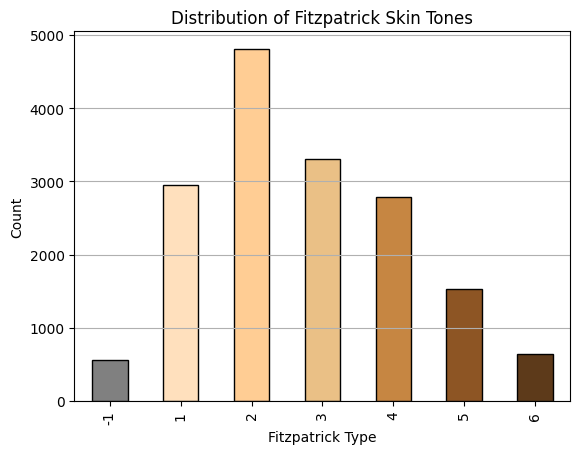

In [ ]:
# Color code for the different skin tones (fitzpatrick scale)
fitz_colors = {
    -1: '#808080',  # NA (mising value!, it may be burnt tissue...)
    1: '#ffe0bd',   # Fitz 1
    2: '#ffcd94',   # Fitz 2
    3: '#eac086',   # Fitz 3
    4: '#c68642',   # Fitz 4
    5: '#8d5524',   # Fitz 5
    6: '#5d3a1a'    # Fitz 6
}

# Get value counts sorted by index
counts = fitz_data['fitzpatrick_scale'].value_counts().sort_index()

# Assign colors for each bar
colors = [fitz_colors.get(i, '#000000') for i in counts.index]

# Do the plot of the distribution according to the skin colors
counts.plot(kind='bar', edgecolor='black', color=colors)
plt.title('Distribution of Fitzpatrick Skin Tones')
plt.xlabel('Fitzpatrick Type')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

Well, the above chunk of code gave us information about the skin tone distribution, but not about the specific diseases. Now, we can examine their distribution conditioned on specific skin tones. We'll start with the three superclasses, which are split into: **benign**, **malignant**, and **non-neoplastic**.

Bear in mind that the dangerous skin conditions are grouped under the **malignant** class.


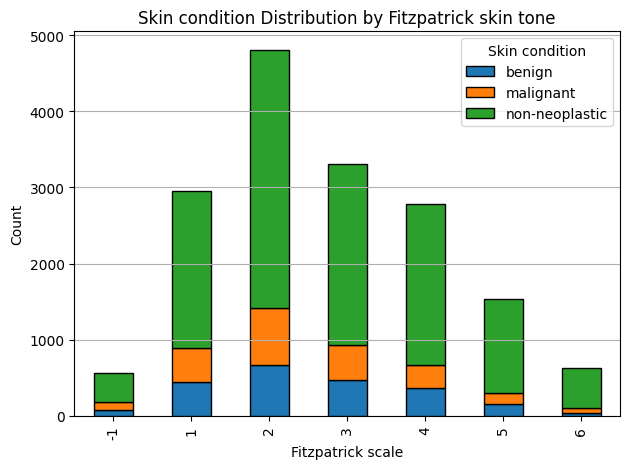

In [ ]:
# We do a bidimensional table of the two categories: skin tone and three superclass labels
cross_tab = pd.crosstab(fitz_data['fitzpatrick_scale'], fitz_data['three_partition_label'])

# Sort by index (X-axis order)
cross_tab = cross_tab.sort_index()

# Do a similar plot to the previous one, but this time we show the labels of the three super classes
cross_tab.plot(kind='bar', stacked=True, edgecolor='black')
plt.title('Skin condition Distribution by Fitzpatrick skin tone')
plt.xlabel('Fitzpatrick scale')
plt.ylabel('Count')
plt.legend(title='Skin condition')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Now, we further divide them into **nine distinct superclasses**. These categories provide a finer-grained classification compared to the previous three high-level partitions (benign, malignant, and non-neoplastic).

Before proceeding with this nine-class visualization, it is important to first understand **which specific conditions (labels)** fall under each of the three superclasses.

In the next step, we will display a grouped summary showing the relationship between the original condition labels and their corresponding nine-partition superclass.


In [ ]:
# We group the three superclasses among the nine super classes
superclass_mapping = fitz_data.groupby('three_partition_label')['nine_partition_label'].unique()

# To dictionary
superclass_mapping_dict = superclass_mapping.to_dict()

# Print this hierarchical data structure!
for superclass, labels in superclass_mapping_dict.items():
    print(f"\nSuperclass: {superclass}")
    print("Labels:")
    for label in labels:
        print(f" - {label}")


Superclass: benign
Labels:
 - benign dermal
 - benign epidermal
 - benign melanocyte

Superclass: malignant
Labels:
 - malignant dermal
 - malignant melanoma
 - malignant epidermal
 - malignant cutaneous lymphoma

Superclass: non-neoplastic
Labels:
 - inflammatory
 - genodermatoses


We now present a visualization of the dataset based on the `nine_partition_label`. This plot provides an overview of how the different skin tones are distributed among the nine diagnostic categories, giving insight into class balance, potential biases, and the relative frequency of each condition type.

Visualizing this distribution is especially important when building machine learning models, as it helps identify class imbalances that could impact model performance. For instance, if certain classes are underrepresented, additional preprocessing or balancing techniques may be required.

The following plot offers a clear summary of the dataset composition under the nine-class classification scheme.


/tmp/ipython-input-3704349199.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


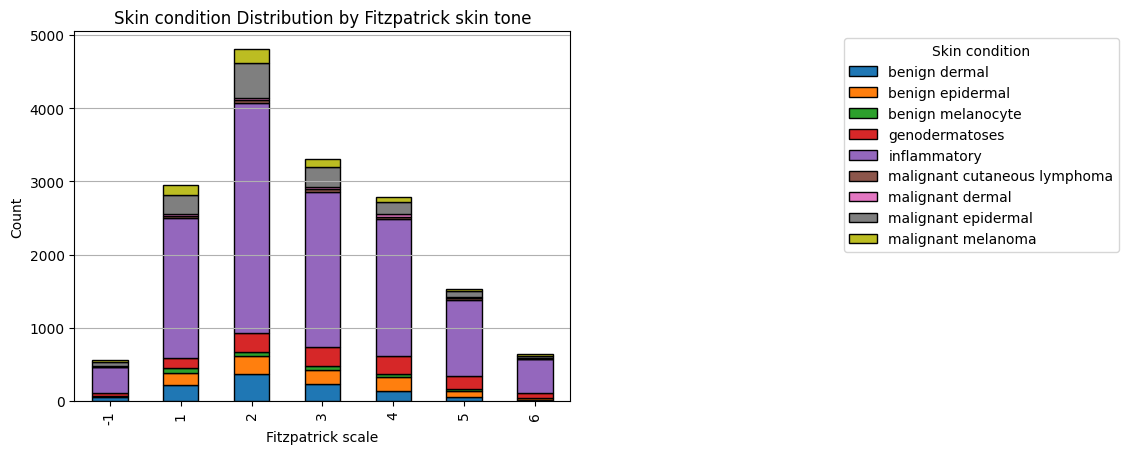

In [ ]:
# Bidimensional table of tones and classes
cross_tab = pd.crosstab(fitz_data['fitzpatrick_scale'], fitz_data['nine_partition_label'])

# Sort by index (X-axis order)
cross_tab = cross_tab.sort_index()

# Plot the distribution of the ninesuperclasses
cross_tab.plot(kind='bar', stacked=True, edgecolor='black')
plt.title('Skin condition Distribution by Fitzpatrick skin tone')
plt.xlabel('Fitzpatrick scale')
plt.ylabel('Count')
plt.legend(title='Skin condition',bbox_to_anchor=(2.12, 1), loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## <font color='red'>First discussion round</font>

### Skin Tone Representation

From the exploratory analysis, we can reflect on the representation of different skin tones in the dataset.

- **Is the distribution balanced across Fitzpatrick skin tones**, or does it appear skewed toward lighter or darker tones?
- If the dataset is imbalanced, **how might this bias the models** we train?

### Disease Representation Across Skin Tones

We should also consider whether **all skin diseases are well-represented across the full spectrum of skin tones**.

- Are certain diseases **underrepresented on specific skin tones**?
- Do some diseases appear **more difficult to visually diagnose** on certain tones due to contrast or pigmentation differences?

### Potential Solutions

Now, we need to plan possible solutions to mitigate biases in order **to build a fair system**.

- How do you think these datasets **might look in real-world systems** deployed in clinical settings? Would they be fair?  
- Can you think of **potential solutions** to address this problem?


## Hyperparameters for model training

In the next chunk of code, we define several key parameters for our experiment. First, we specify the **random seed**, which ensures reproducibility and allows us to perform multiple runs with different seeds for more robust evaluation.

Next, we configure the **optimization process**, including the number of **training epochs** and the **batch size**. These hyperparameters play a critical role in the learning dynamics of the model.

We also define the **input image size**, which determines how images will be resized before being fed into the model, and the **test set size**, which controls how much of the dataset is held out for evaluation.

Finally, we specify the **path to the dataset**, which allows the code to locate and load the images and labels correctly.


In [ ]:
# Experiment Configuration
run = 5 # current run (seed)

# Configuration of the training
batch_size = 128
num_epochs = 50

# Data configs
dataset_root = 'drive/MyDrive/SKIN/dataset/'
test_size = 500
image_size = 224

print("############## Let's go with run (seed)", run)

############## Let's go with run (seed) 5


## Experiment


To investigate potential **racial biases** and evaluate **classification performance across different skin tones**, we define the following controlled experiment.

### Data Partitioning by Skin Tone

We categorize the dataset into two distinct groups based on the **Fitzpatrick skin tone (FST)** scale:

- **Light skin tones**: FST 1–2
- **Dark skin tones**: FST 5–6

Samples labeled as **FST 3–4** are excluded from this experiment to avoid ambiguity and reduce overlap between groups.

---

### Training Set Configurations

We create three separate training sets, each consisting of **1,000 samples**, but with varying proportions of dark and light skin tones. These configurations allow us to evaluate how training set composition affects model fairness and accuracy.

| Dataset | Composition | Description |
|--------|-------------|-------------|
| **A** | 100% light samples | *Light-biased dataset* |
| **B** | 50% light, 50% dark | *Balanced skin tone dataset* |
| **C** | 100% dark samples | *Dark-biased dataset* |

Each training set is designed to be equal in size (1,000 samples), ensuring that performance differences are attributable to **skin tone distribution**, not sample size.

---

### Test Sets

To fairly evaluate performance across skin tones, we define two separate test sets:

- **Light Test Set**: Contains only light (FST 1–2) samples
- **Dark Test Set**: Contains only dark (FST 5–6) samples

This allows us to assess model accuracy and generalization across **sensitive subgroups** and observe whether the training set composition introduces any bias.

---

This experimental design enables us to measure both **model fairness** and **performance disparities**, helping to discern whether models trained on imbalanced data may systematically underperform on underrepresented skin tones.


## Data loading

### Sampling Function for Experimental Configuration

We begin by defining a function to generate the training and test sets for our experimental setup.

This function supports flexible configuration through the following parameters:

- **`perc_black`**: Controls the proportion of dark skin tone (FST 5–6) samples in the training set. We use values of `0` (all light), `0.5` (balanced), and `1` (all dark) to simulate three training conditions.
- **`run`**: An integer used as a random seed to ensure reproducibility across different experimental runs.
- **`test_size`**: Specifies the number of samples to include in each of the two test sets (light and dark), allowing us to control evaluation size.

The function filters out ambiguous FST 3–4 samples and samples the training and test data accordingly. This setup ensures consistent and fair comparisons across configurations with controlled dataset compositions.

In [ ]:
# Function to sample training and test set depending on the configuration
def train_test_fitz(dataset_root, perc_black, run, test_size):
    # Read the dataframe
    df = pd.read_csv(dataset_root + "fitzpatrick17k.csv")

    # Keep only white and black Fitzpatrick groups (discard FST 3-4)
    df = df[df['fitzpatrick_scale'].isin([1, 2, 5, 6])]

    # Create simplified race group - we will call white and black
    df['race_group'] = df['fitzpatrick_scale'].apply(lambda x: 'white' if x in [1, 2] else 'black')

    # Create combined stratification key for test split: each instance will be labeled with the class and the race group
    df['stratify_key'] = df['three_partition_label'].astype(str) + "_" + df['race_group']

    # Stratified split into train and test by combined key (we expect to obtain an even distribution of tones and classes)
    train_df, test_df = train_test_split(
        df,
        test_size=test_size, # option we selected to define the test size
        stratify=df['stratify_key'],
        random_state=run
    )

    ## Now we separate the racial groups:

    # Separate test data by race
    test_w = test_df[test_df['race_group'] == 'white']
    test_b = test_df[test_df['race_group'] == 'black']

    # Separate train data by race
    white_df = train_df[train_df['race_group'] == 'white']
    black_df = train_df[train_df['race_group'] == 'black']

    # Handle edge cases for perc_black = 0 or 1
    if perc_black == 0:
        # Only white samples for training
        white_train_size = len(white_df)
        white_df, _ = train_test_split(
            white_df,
            train_size=1000,
            stratify=white_df['three_partition_label'],
            random_state=run
        )
        train_df = white_df
    elif perc_black >= 1:
        # Only black samples for training
        black_train_size = len(black_df)
        black_df, _ = train_test_split(
            black_df,
            train_size=1000,
            stratify=black_df['three_partition_label'],
            random_state=run
        )
        train_df = black_df
    else:
        # Mix of black and white samples (select the percentage of black)

        # Calculate training sizes as integers
        total_group_size = min(len(black_df), len(white_df))
        n_black = int(round(perc_black * total_group_size))
        n_white = int(round((1 - perc_black) * total_group_size))

        # Clamp minimum 1 to avoid zero sample errors
        n_black = max(n_black, 1)
        n_white = max(n_white, 1)

        # Stratified sampling inside each race group
        white_df, _ = train_test_split(
            white_df,
            train_size=500,
            stratify=white_df['three_partition_label'],
            random_state=run
        )

        black_df, _ = train_test_split(
            black_df,
            train_size=500,
            stratify=black_df['three_partition_label'],
            random_state=run
        )

        train_df = pd.concat([white_df, black_df])

    # Debug prints for distributions
    print("Train distribution (three_partition_label, race):\n", train_df.groupby(['three_partition_label', 'race_group']).size())
    print("Test distribution (three_partition_label, race):\n", test_df.groupby(['three_partition_label', 'race_group']).size())
    print("Test white count:", len(test_w), "| Test black count:", len(test_b))

    # Class weights for imbalance: we penalize in the loss function underrepresented classes
    label_mapping = {'non-neoplastic': 0, 'malignant': 1, 'benign': 2} # from str to int
    int_labels = [label_mapping[label] for label in train_df['three_partition_label'].tolist()]
    class_counts = collections.Counter(int_labels)
    print("Class distribution in training: ", class_counts)
    num_classes = len(class_counts)
    total_samples = len(int_labels)
    class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    print("Weights: ", class_weights)

    # Create fitz dataset objects for the dataloaders
    train_dataset = fitz_dataset(train_df, dataset_root + 'imgs/finalfitz17k/', image_size, test=False)
    test_dataset_w = fitz_dataset(test_w, dataset_root + 'imgs/finalfitz17k/', image_size, test=True)
    test_dataset_b = fitz_dataset(test_b, dataset_root + 'imgs/finalfitz17k/', image_size, test=True)

    return train_dataset, test_dataset_w, test_dataset_b, class_weights



### Custom Dataset Class for Loading and Augmenting Images

The following class is responsible for loading the dataset and preparing it for training and evaluation. It inherits from the `Dataset` class provided by **PyTorch**, which enables compatibility with the PyTorch `DataLoader`.

To initialize the class, we pass a **Pandas DataFrame** containing the relevant information for each image, such as file paths, labels, and metadata.

The class handles the following key functionalities:

- **Image loading**: Reads each image file from the dataset based on the provided path.
- **Label assignment**: Retrieves the correct label (e.g., for classification) from the DataFrame.
- **Data augmentation**: Applies a set of transformations (e.g., random flips, rotations, normalization) to enhance generalization and reduce overfitting.
    - These augmentations are only applied during **training**.
    - A boolean argument `test` is used to control this behavior: if `test=True`, the dataset skips augmentation and applies only necessary preprocessing for evaluation.

This modular design allows us to efficiently load, preprocess, and batch the data using a PyTorch `DataLoader`, making the dataset ready for model training or inference.


In [ ]:
class fitz_dataset(Dataset):
    def __init__(self, dataframe, img_dir, image_size, test=False):

        # Read dataframe
        self.dataframe = dataframe
        imgs = os.listdir(img_dir)
        imgs_hash = [x.split('.')[0] for x in imgs]
        # Match the hash of the dataframe and the images in the directory, this will be our utilized data
        self.intersection = list(set(dataframe['md5hash']).intersection(imgs_hash))
        self.images_fps = [img_dir + x + '.jpg' for x in self.intersection] # names for reading the images

        # Data augmentation
        if test:
            self.transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
                                ])
        else:
            self.transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
                                ])

        self.label_mapping_3 = {'non-neoplastic': 0, 'malignant': 1, 'benign': 2}

        self.label_mapping_9 = {'inflammatory': 0, 'malignant epidermal': 1, 'genodermatoses': 2,
                               'benign dermal': 3, 'benign epidermal': 4, 'malignant melanoma': 5,
                               'benign melanocyte': 6, 'malignant cutaneous lymphoma': 7,
                               'malignant dermal': 8}


    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, idx):
        # Get features and target
        # read data
        img = Image.open(self.images_fps[idx])
        img = img.convert("RGB")

        image = self.transform(img)


        return image, self.intersection[idx]

    def __getitem__(self, idx):
        # Get the image filepath
        img_path = self.images_fps[idx]
        img = Image.open(img_path).convert("RGB")
        image = self.transform(img)

        # Get the image hash (filename without extension)
        img_hash = self.intersection[idx]

        # Get the corresponding row in the dataframe
        row = self.dataframe[self.dataframe['md5hash'] == img_hash].iloc[0]

        # Extract the three labels
        label_3 = self.label_mapping_3[row['three_partition_label']]

        # Optionally convert to long tensor for the torch loss
        labels = torch.tensor(label_3, dtype=torch.long)

        return image, labels, img_hash

## <font color='red'>Second Discussion Round
</font>

Now, in this second round of discussion about the class dataset, let’s go deeper into how the dataset is used.

### Sampling strategy

- How are the **training and test sets defined** in this context?  
- Do you think there are **more effective ways to split the data** (e.g., cross-validation, stratified sampling)? Why or why not? Which limitations do we face?

### Data preprocessing

- What are your thoughts on the **preprocessing steps** used in this dataset? Are there any improvements or best practices you would suggest?
- What role do you think **data augmentation** can play here? Could it help reduce bias, improve generalization, or introduce new issues?

## Model definition, and training loop


### Model Definition and Training Procedure

This function defines and executes the entire training pipeline for our classification task.

We use a **pretrained EfficientNet-B0** model from ImageNet as the backbone. By fine-tuning this model on our specific dataset, we leverage powerful pretrained features while adapting the network to the task of skin disease classification.

Key components of the function:

- **Model Initialization**:
    - Uses `EfficientNet-B0` from `torchvision.models` or `efficientnet_pytorch`.
    - The classifier head is modified to match the number of output classes in our task (in this case, 3: benign, malignant, and non-neoplastic).

- **Loss Function**:
    - We use **CrossEntropyLoss** with optional **class weights** to address imbalanced class distributions.
    - These weights help penalize underrepresented classes more heavily during training, improving performance on minority classes.

- **Optimizer and Training Loop**:
    - We define an optimizer (e.g., Adam or SGD) and implement the training loop with evaluation checkpoints. In this case, we use Adam.
    - At regular intervals (e.g., after each epoch), the model is evaluated on the validation/test set.
    - Metrics such as loss and accuracy are tracked for both training and testing phases.

- **Device Support**:
    - The function automatically uses **CUDA** if available, enabling GPU acceleration for faster training.

Once the data is prepared and passed into the function (training and test loaders), the model is trained and evaluated in a streamlined and reproducible way.


In [ ]:
def train_evaluate_model(train_loader, test_loader, test_loader_w, test_loader_b, class_weights, num_epochs):
    # --- Model ---
    # use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("We are running on ", device)
    # load the network
    model = timm.create_model('efficientnet_b0', pretrained=True)
    in_features = model.classifier.in_features
    # define the head
    output_classes = 3
    model.classifier = nn.Linear(in_features,output_classes)
    print(output_classes)
    # put the data into the device (gpu/cpu)
    model = model.to(device)
    class_weights_device = class_weights.to(device)
    # loss and optimizer
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    def unnormalize(tensor):
        # normalization for the pretrained network
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        return tensor * std + mean

    def test_model(test_loader, model, subgroup):
        test_loss = 0
        test_correct = 0
        test_total = 0
        all_labels = []
        all_preds = []
        shown = 0

        with torch.no_grad():
            for images, labels, ids in test_loader:
                images, labels = images.to(device), labels.to(device)
                # pass forward
                outputs = model(images)
                # compute the loss
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        # compute the metrics
        test_loss /= test_total
        acc = test_correct / test_total
        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f"Epoch {epoch+1}/{num_epochs} Test loss: {test_loss:.4f} Acc: {acc:.4f} F1: {f1:.4f} Subgroup: {subgroup}")
        print(collections.Counter(all_labels), collections.Counter(all_preds))
        print(classification_report(all_labels, all_preds))
        return f1

    # --- Training Loop ---

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Wrap with tqdm and store the progress bar object
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels, ids in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            # pass forward
            outputs = model(images)
            # compute the loss
            loss = criterion(outputs, labels)
            # back propagation and update of the parameters
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Show running average loss and accuracy
            current_loss = running_loss / total
            current_acc = correct / total
            pbar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")



        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} Train loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Test
        model.eval()
        test_w = test_model(test_loader_w, model, 'Light tones')
        test_b = test_model(test_loader_b, model, 'Dark tones')

    return test_w, test_b


### Training Loop Across Skin Tone Configurations

In this step, we define a loop to run our experiment for a selected random seed (`run`).

For each run, we **sample three different training sets** according to the percentage of dark-skinned (FST 5–6) samples:
- **Dataset A**: 0% dark samples (light-only)
- **Dataset B**: 50% dark, 50% light (balanced)
- **Dataset C**: 100% dark samples

For each configuration:
1. We **sample the training and test sets** using the predefined sampling function.
2. We **train a model** on the corresponding training set.
3. We **evaluate the model** on both light and dark test sets.
4. We **store the performance metrics** (e.g., accuracy, loss, F1 score) for later analysis.

All results are saved in a structured format for later visualization. This enables us to compare performance across different training distributions and assess how skin tone representation in training data affects model fairness and accuracy.

In [ ]:
# Dictionary to store everything
perc_black_values = [0.0, 0.5, 1.0]
results = {}

for subset in perc_black_values:

    perc_black = int(subset) if subset == 0.0 or subset == 1.0 else subset
    # Get datasets
    train_dataset, test_dataset_white, test_dataset_black, class_weights = train_test_fitz(
        dataset_root, perc_black, run, test_size
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader_white = DataLoader(test_dataset_white, batch_size=batch_size, shuffle=False)
    test_loader_black = DataLoader(test_dataset_black, batch_size=batch_size, shuffle=False)

    # Call training/evaluation function
    result = train_evaluate_model(
        train_loader=train_loader,
        test_loader=test_loader_white,  # General test loader (can be avg or main test)
        test_loader_w=test_loader_white,
        test_loader_b=test_loader_black,
        class_weights=class_weights,
        num_epochs=30
    )

    # Save everything in the dictionary
    results[perc_black] = {
        'datasets': {
            'train': train_dataset,
            'test_white': test_dataset_white,
            'test_black': test_dataset_black
        },
        'loaders': {
            'train': train_loader,
            'test_white': test_loader_white,
            'test_black': test_loader_black
        },
        'class_weights': class_weights,
        'training_result': result
    }

Train distribution (three_partition_label, race):
 three_partition_label  race_group
benign                 white         144
malignant              white         154
non-neoplastic         white         702
dtype: int64
Test distribution (three_partition_label, race):
 three_partition_label  race_group
benign                 black          10
                       white          56
malignant              black          11
                       white          60
non-neoplastic         black          89
                       white         274
dtype: int64
Test white count: 390 | Test black count: 110
Class distribution in training:  Counter({0: 702, 1: 154, 2: 144})
Weights:  tensor([0.4748, 2.1645, 2.3148])
We are running on  cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

3


Epoch 1/30: 100%|██████████| 7/7 [06:18<00:00, 54.12s/it, acc=0.3795, loss=1.0988]


Epoch 1/30 Train loss: 1.0988 Acc: 0.3795
Epoch 1/30 Test loss: 1.0712 Acc: 0.5410 F1: 0.4231 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 216, np.int64(1): 118, np.int64(2): 56})
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       274
           1       0.27      0.53      0.36        60
           2       0.23      0.23      0.23        56

    accuracy                           0.54       390
   macro avg       0.42      0.46      0.42       390
weighted avg       0.61      0.54      0.56       390

Epoch 1/30 Test loss: 1.0443 Acc: 0.5909 F1: 0.4182 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 64, np.int64(1): 27, np.int64(2): 19})
              precision    recall  f1-score   support

           0       0.88      0.63      0.73        89
           1       0.22      0.55      0.32        11
           2       0

Epoch 2/30: 100%|██████████| 7/7 [00:19<00:00,  2.74s/it, acc=0.6116, loss=0.9292]


Epoch 2/30 Train loss: 0.9292 Acc: 0.6116
Epoch 2/30 Test loss: 1.0109 Acc: 0.5641 F1: 0.4567 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 201, np.int64(1): 129, np.int64(2): 60})
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       274
           1       0.32      0.68      0.43        60
           2       0.23      0.25      0.24        56

    accuracy                           0.56       390
   macro avg       0.46      0.51      0.46       390
weighted avg       0.66      0.56      0.59       390

Epoch 2/30 Test loss: 1.0360 Acc: 0.5000 F1: 0.3071 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 56, np.int64(1): 43, np.int64(2): 11})
              precision    recall  f1-score   support

           0       0.86      0.54      0.66        89
           1       0.16      0.64      0.26        11
           2       0

Epoch 3/30: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it, acc=0.6886, loss=0.8127]


Epoch 3/30 Train loss: 0.8127 Acc: 0.6886
Epoch 3/30 Test loss: 0.9704 Acc: 0.5538 F1: 0.4651 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 187, np.int64(1): 125, np.int64(2): 78})
              precision    recall  f1-score   support

           0       0.83      0.57      0.68       274
           1       0.34      0.72      0.46        60
           2       0.22      0.30      0.25        56

    accuracy                           0.55       390
   macro avg       0.47      0.53      0.47       390
weighted avg       0.67      0.55      0.58       390

Epoch 3/30 Test loss: 1.0295 Acc: 0.5182 F1: 0.3591 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 52, np.int64(1): 44, np.int64(2): 14})
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        89
           1       0.20      0.82      0.33        11
           2       0

Epoch 4/30: 100%|██████████| 7/7 [00:13<00:00,  1.95s/it, acc=0.7489, loss=0.7126]


Epoch 4/30 Train loss: 0.7126 Acc: 0.7489
Epoch 4/30 Test loss: 0.9468 Acc: 0.5769 F1: 0.4895 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 193, np.int64(1): 120, np.int64(2): 77})
              precision    recall  f1-score   support

           0       0.84      0.59      0.69       274
           1       0.37      0.73      0.49        60
           2       0.25      0.34      0.29        56

    accuracy                           0.58       390
   macro avg       0.48      0.55      0.49       390
weighted avg       0.68      0.58      0.60       390

Epoch 4/30 Test loss: 1.0030 Acc: 0.5364 F1: 0.3919 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 53, np.int64(1): 42, np.int64(2): 15})
              precision    recall  f1-score   support

           0       0.91      0.54      0.68        89
           1       0.21      0.82      0.34        11
           2       0

Epoch 5/30: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it, acc=0.7746, loss=0.6108]


Epoch 5/30 Train loss: 0.6108 Acc: 0.7746
Epoch 5/30 Test loss: 0.9357 Acc: 0.5974 F1: 0.5013 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 209, np.int64(1): 102, np.int64(2): 79})
              precision    recall  f1-score   support

           0       0.83      0.63      0.72       274
           1       0.40      0.68      0.51        60
           2       0.24      0.34      0.28        56

    accuracy                           0.60       390
   macro avg       0.49      0.55      0.50       390
weighted avg       0.68      0.60      0.62       390

Epoch 5/30 Test loss: 0.9797 Acc: 0.5364 F1: 0.4056 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 54, np.int64(1): 33, np.int64(2): 23})
              precision    recall  f1-score   support

           0       0.89      0.54      0.67        89
           1       0.24      0.73      0.36        11
           2       0

Epoch 6/30: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it, acc=0.8114, loss=0.5095]


Epoch 6/30 Train loss: 0.5095 Acc: 0.8114
Epoch 6/30 Test loss: 0.9334 Acc: 0.5949 F1: 0.4977 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 214, np.int64(1): 89, np.int64(2): 87})
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       274
           1       0.43      0.63      0.51        60
           2       0.22      0.34      0.27        56

    accuracy                           0.59       390
   macro avg       0.49      0.54      0.50       390
weighted avg       0.67      0.59      0.62       390

Epoch 6/30 Test loss: 0.9672 Acc: 0.6000 F1: 0.4492 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 61, np.int64(1): 26, np.int64(2): 23})
              precision    recall  f1-score   support

           0       0.90      0.62      0.73        89
           1       0.31      0.73      0.43        11
           2       0.

Epoch 7/30: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it, acc=0.8504, loss=0.4170]


Epoch 7/30 Train loss: 0.4170 Acc: 0.8504
Epoch 7/30 Test loss: 0.9284 Acc: 0.6154 F1: 0.5117 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 224, np.int64(2): 86, np.int64(1): 80})
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       274
           1       0.46      0.62      0.53        60
           2       0.22      0.34      0.27        56

    accuracy                           0.62       390
   macro avg       0.50      0.54      0.51       390
weighted avg       0.68      0.62      0.64       390

Epoch 7/30 Test loss: 0.9637 Acc: 0.6273 F1: 0.4523 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 67, np.int64(1): 26, np.int64(2): 17})
              precision    recall  f1-score   support

           0       0.88      0.66      0.76        89
           1       0.27      0.64      0.38        11
           2       0.

Epoch 8/30: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it, acc=0.8672, loss=0.3632]


Epoch 8/30 Train loss: 0.3632 Acc: 0.8672
Epoch 8/30 Test loss: 0.9319 Acc: 0.6333 F1: 0.5130 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 240, np.int64(2): 76, np.int64(1): 74})
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       274
           1       0.46      0.57      0.51        60
           2       0.24      0.32      0.27        56

    accuracy                           0.63       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.68      0.63      0.65       390

Epoch 8/30 Test loss: 0.9722 Acc: 0.6364 F1: 0.4348 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 72, np.int64(1): 23, np.int64(2): 15})
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        89
           1       0.22      0.45      0.29        11
           2       0.

Epoch 9/30: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it, acc=0.9118, loss=0.2939]


Epoch 9/30 Train loss: 0.2939 Acc: 0.9118
Epoch 9/30 Test loss: 0.9555 Acc: 0.6590 F1: 0.5250 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 256, np.int64(2): 72, np.int64(1): 62})
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       274
           1       0.52      0.53      0.52        60
           2       0.24      0.30      0.27        56

    accuracy                           0.66       390
   macro avg       0.52      0.53      0.53       390
weighted avg       0.68      0.66      0.67       390

Epoch 9/30 Test loss: 0.9778 Acc: 0.6636 F1: 0.4517 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 75, np.int64(1): 21, np.int64(2): 14})
              precision    recall  f1-score   support

           0       0.87      0.73      0.79        89
           1       0.24      0.45      0.31        11
           2       0.

Epoch 10/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.9252, loss=0.2456]


Epoch 10/30 Train loss: 0.2456 Acc: 0.9252
Epoch 10/30 Test loss: 0.9827 Acc: 0.6872 F1: 0.5356 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 271, np.int64(1): 60, np.int64(2): 59})
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       274
           1       0.50      0.50      0.50        60
           2       0.29      0.30      0.30        56

    accuracy                           0.69       390
   macro avg       0.53      0.54      0.54       390
weighted avg       0.69      0.69      0.69       390

Epoch 10/30 Test loss: 0.9970 Acc: 0.6909 F1: 0.4175 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 82, np.int64(1): 20, np.int64(2): 8})
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        89
           1       0.25      0.45      0.32        11
           2       

Epoch 11/30: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it, acc=0.9397, loss=0.2025]


Epoch 11/30 Train loss: 0.2025 Acc: 0.9397
Epoch 11/30 Test loss: 1.0113 Acc: 0.7026 F1: 0.5463 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 278, np.int64(1): 58, np.int64(2): 54})
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       274
           1       0.53      0.52      0.53        60
           2       0.30      0.29      0.29        56

    accuracy                           0.70       390
   macro avg       0.55      0.54      0.55       390
weighted avg       0.70      0.70      0.70       390

Epoch 11/30 Test loss: 1.0217 Acc: 0.6909 F1: 0.4175 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 82, np.int64(1): 20, np.int64(2): 8})
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        89
           1       0.25      0.45      0.32        11
           2       

Epoch 12/30: 100%|██████████| 7/7 [00:14<00:00,  2.04s/it, acc=0.9721, loss=0.1578]


Epoch 12/30 Train loss: 0.1578 Acc: 0.9721
Epoch 12/30 Test loss: 1.0529 Acc: 0.7205 F1: 0.5527 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 290, np.int64(1): 58, np.int64(2): 42})
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       274
           1       0.57      0.55      0.56        60
           2       0.31      0.23      0.27        56

    accuracy                           0.72       390
   macro avg       0.56      0.55      0.55       390
weighted avg       0.70      0.72      0.71       390

Epoch 12/30 Test loss: 1.0593 Acc: 0.7455 F1: 0.4354 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 91, np.int64(1): 15, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        89
           1       0.27      0.36      0.31        11
           2       

Epoch 13/30: 100%|██████████| 7/7 [00:14<00:00,  2.12s/it, acc=0.9821, loss=0.1284]


Epoch 13/30 Train loss: 0.1284 Acc: 0.9821
Epoch 13/30 Test loss: 1.1017 Acc: 0.7231 F1: 0.5561 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 292, np.int64(1): 56, np.int64(2): 42})
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       274
           1       0.59      0.55      0.57        60
           2       0.31      0.23      0.27        56

    accuracy                           0.72       390
   macro avg       0.57      0.55      0.56       390
weighted avg       0.70      0.72      0.71       390

Epoch 13/30 Test loss: 1.1040 Acc: 0.7455 F1: 0.4379 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 92, np.int64(1): 14, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        89
           1       0.29      0.36      0.32        11
           2       

Epoch 14/30: 100%|██████████| 7/7 [00:14<00:00,  2.12s/it, acc=0.9810, loss=0.1047]


Epoch 14/30 Train loss: 0.1047 Acc: 0.9810
Epoch 14/30 Test loss: 1.1605 Acc: 0.7231 F1: 0.5435 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 299, np.int64(1): 50, np.int64(2): 41})
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       274
           1       0.60      0.50      0.55        60
           2       0.29      0.21      0.25        56

    accuracy                           0.72       390
   macro avg       0.57      0.53      0.54       390
weighted avg       0.70      0.72      0.71       390

Epoch 14/30 Test loss: 1.1620 Acc: 0.7455 F1: 0.4379 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 92, np.int64(1): 14, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        89
           1       0.29      0.36      0.32        11
           2       

Epoch 15/30: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it, acc=0.9933, loss=0.0834]


Epoch 15/30 Train loss: 0.0834 Acc: 0.9933
Epoch 15/30 Test loss: 1.2038 Acc: 0.7231 F1: 0.5450 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 299, np.int64(1): 49, np.int64(2): 42})
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       274
           1       0.59      0.48      0.53        60
           2       0.31      0.23      0.27        56

    accuracy                           0.72       390
   macro avg       0.57      0.53      0.55       390
weighted avg       0.70      0.72      0.71       390

Epoch 15/30 Test loss: 1.2136 Acc: 0.7636 F1: 0.4514 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 12, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        89
           1       0.33      0.36      0.35        11
           2       

Epoch 16/30: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it, acc=0.9978, loss=0.0630]


Epoch 16/30 Train loss: 0.0630 Acc: 0.9978
Epoch 16/30 Test loss: 1.2568 Acc: 0.7231 F1: 0.5346 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 304, np.int64(1): 50, np.int64(2): 36})
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       274
           1       0.58      0.48      0.53        60
           2       0.31      0.20      0.24        56

    accuracy                           0.72       390
   macro avg       0.56      0.52      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 16/30 Test loss: 1.2835 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 17/30: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, acc=0.9967, loss=0.0498]


Epoch 17/30 Train loss: 0.0498 Acc: 0.9967
Epoch 17/30 Test loss: 1.2862 Acc: 0.7333 F1: 0.5522 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 300, np.int64(1): 56, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       274
           1       0.59      0.55      0.57        60
           2       0.32      0.20      0.24        56

    accuracy                           0.73       390
   macro avg       0.57      0.54      0.55       390
weighted avg       0.70      0.73      0.72       390

Epoch 17/30 Test loss: 1.3284 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 18/30: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it, acc=0.9978, loss=0.0378]


Epoch 18/30 Train loss: 0.0378 Acc: 0.9978
Epoch 18/30 Test loss: 1.3453 Acc: 0.7333 F1: 0.5440 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 307, np.int64(1): 52, np.int64(2): 31})
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       274
           1       0.58      0.50      0.54        60
           2       0.35      0.20      0.25        56

    accuracy                           0.73       390
   macro avg       0.58      0.53      0.54       390
weighted avg       0.70      0.73      0.71       390

Epoch 18/30 Test loss: 1.3943 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 19/30: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it, acc=0.9989, loss=0.0309]


Epoch 19/30 Train loss: 0.0309 Acc: 0.9989
Epoch 19/30 Test loss: 1.3821 Acc: 0.7256 F1: 0.5417 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 302, np.int64(1): 54, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       274
           1       0.57      0.52      0.54        60
           2       0.32      0.20      0.24        56

    accuracy                           0.73       390
   macro avg       0.57      0.53      0.54       390
weighted avg       0.70      0.73      0.71       390

Epoch 19/30 Test loss: 1.4350 Acc: 0.7727 F1: 0.4565 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 95, np.int64(1): 13, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        89
           1       0.31      0.36      0.33        11
           2       

Epoch 20/30: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it, acc=0.9989, loss=0.0269]


Epoch 20/30 Train loss: 0.0269 Acc: 0.9989
Epoch 20/30 Test loss: 1.4115 Acc: 0.7231 F1: 0.5343 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 305, np.int64(1): 51, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       274
           1       0.57      0.48      0.52        60
           2       0.32      0.20      0.24        56

    accuracy                           0.72       390
   macro avg       0.56      0.52      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 20/30 Test loss: 1.4715 Acc: 0.7727 F1: 0.4565 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 95, np.int64(1): 13, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        89
           1       0.31      0.36      0.33        11
           2       

Epoch 21/30: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it, acc=1.0000, loss=0.0212]


Epoch 21/30 Train loss: 0.0212 Acc: 1.0000
Epoch 21/30 Test loss: 1.4499 Acc: 0.7205 F1: 0.5257 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 306, np.int64(1): 48, np.int64(2): 36})
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       274
           1       0.56      0.45      0.50        60
           2       0.31      0.20      0.24        56

    accuracy                           0.72       390
   macro avg       0.55      0.51      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 21/30 Test loss: 1.5196 Acc: 0.7727 F1: 0.4565 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 95, np.int64(1): 13, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        89
           1       0.31      0.36      0.33        11
           2       

Epoch 22/30: 100%|██████████| 7/7 [00:13<00:00,  1.98s/it, acc=1.0000, loss=0.0177]


Epoch 22/30 Train loss: 0.0177 Acc: 1.0000
Epoch 22/30 Test loss: 1.4704 Acc: 0.7231 F1: 0.5305 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 306, np.int64(1): 50, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       274
           1       0.56      0.47      0.51        60
           2       0.32      0.20      0.24        56

    accuracy                           0.72       390
   macro avg       0.56      0.52      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 22/30 Test loss: 1.5446 Acc: 0.7636 F1: 0.4500 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 14, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        89
           1       0.29      0.36      0.32        11
           2       

Epoch 23/30: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it, acc=1.0000, loss=0.0147]


Epoch 23/30 Train loss: 0.0147 Acc: 1.0000
Epoch 23/30 Test loss: 1.4995 Acc: 0.7282 F1: 0.5308 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 308, np.int64(1): 52, np.int64(2): 30})
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       274
           1       0.56      0.48      0.52        60
           2       0.33      0.18      0.23        56

    accuracy                           0.73       390
   macro avg       0.56      0.52      0.53       390
weighted avg       0.69      0.73      0.70       390

Epoch 23/30 Test loss: 1.5670 Acc: 0.7545 F1: 0.4438 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 93, np.int64(1): 15, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        89
           1       0.27      0.36      0.31        11
           2       

Epoch 24/30: 100%|██████████| 7/7 [00:14<00:00,  2.12s/it, acc=1.0000, loss=0.0126]


Epoch 24/30 Train loss: 0.0126 Acc: 1.0000
Epoch 24/30 Test loss: 1.5394 Acc: 0.7282 F1: 0.5287 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 310, np.int64(1): 49, np.int64(2): 31})
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       274
           1       0.57      0.47      0.51        60
           2       0.32      0.18      0.23        56

    accuracy                           0.73       390
   macro avg       0.56      0.51      0.53       390
weighted avg       0.69      0.73      0.70       390

Epoch 24/30 Test loss: 1.6143 Acc: 0.7636 F1: 0.4500 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 14, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        89
           1       0.29      0.36      0.32        11
           2       

Epoch 25/30: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it, acc=1.0000, loss=0.0118]


Epoch 25/30 Train loss: 0.0118 Acc: 1.0000
Epoch 25/30 Test loss: 1.5620 Acc: 0.7333 F1: 0.5375 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 310, np.int64(1): 49, np.int64(2): 31})
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       274
           1       0.57      0.47      0.51        60
           2       0.35      0.20      0.25        56

    accuracy                           0.73       390
   macro avg       0.57      0.52      0.54       390
weighted avg       0.70      0.73      0.71       390

Epoch 25/30 Test loss: 1.6315 Acc: 0.7636 F1: 0.4500 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 14, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        89
           1       0.29      0.36      0.32        11
           2       

Epoch 26/30: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it, acc=1.0000, loss=0.0103]


Epoch 26/30 Train loss: 0.0103 Acc: 1.0000
Epoch 26/30 Test loss: 1.5900 Acc: 0.7359 F1: 0.5398 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 311, np.int64(1): 48, np.int64(2): 31})
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       274
           1       0.58      0.47      0.52        60
           2       0.35      0.20      0.25        56

    accuracy                           0.74       390
   macro avg       0.58      0.52      0.54       390
weighted avg       0.70      0.74      0.71       390

Epoch 26/30 Test loss: 1.6684 Acc: 0.7727 F1: 0.4565 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 95, np.int64(1): 13, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        89
           1       0.31      0.36      0.33        11
           2       

Epoch 27/30: 100%|██████████| 7/7 [00:14<00:00,  2.11s/it, acc=1.0000, loss=0.0089]


Epoch 27/30 Train loss: 0.0089 Acc: 1.0000
Epoch 27/30 Test loss: 1.6150 Acc: 0.7410 F1: 0.5502 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 310, np.int64(1): 50, np.int64(2): 30})
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       274
           1       0.60      0.50      0.55        60
           2       0.37      0.20      0.26        56

    accuracy                           0.74       390
   macro avg       0.59      0.53      0.55       390
weighted avg       0.71      0.74      0.72       390

Epoch 27/30 Test loss: 1.6953 Acc: 0.7636 F1: 0.4500 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 14, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        89
           1       0.29      0.36      0.32        11
           2       

Epoch 28/30: 100%|██████████| 7/7 [00:14<00:00,  2.00s/it, acc=1.0000, loss=0.0079]


Epoch 28/30 Train loss: 0.0079 Acc: 1.0000
Epoch 28/30 Test loss: 1.6558 Acc: 0.7410 F1: 0.5452 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 49, np.int64(2): 29})
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       274
           1       0.61      0.50      0.55        60
           2       0.34      0.18      0.24        56

    accuracy                           0.74       390
   macro avg       0.59      0.53      0.55       390
weighted avg       0.70      0.74      0.72       390

Epoch 28/30 Test loss: 1.7374 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 29/30: 100%|██████████| 7/7 [00:13<00:00,  1.95s/it, acc=1.0000, loss=0.0072]


Epoch 29/30 Train loss: 0.0072 Acc: 1.0000
Epoch 29/30 Test loss: 1.6705 Acc: 0.7359 F1: 0.5364 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 46, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       274
           1       0.59      0.45      0.51        60
           2       0.34      0.20      0.25        56

    accuracy                           0.74       390
   macro avg       0.58      0.52      0.54       390
weighted avg       0.70      0.74      0.71       390

Epoch 29/30 Test loss: 1.7554 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 30/30: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it, acc=1.0000, loss=0.0062]


Epoch 30/30 Train loss: 0.0062 Acc: 1.0000
Epoch 30/30 Test loss: 1.6949 Acc: 0.7359 F1: 0.5402 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 48, np.int64(2): 30})
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       274
           1       0.58      0.47      0.52        60
           2       0.37      0.20      0.26        56

    accuracy                           0.74       390
   macro avg       0.58      0.52      0.54       390
weighted avg       0.70      0.74      0.71       390

Epoch 30/30 Test loss: 1.7856 Acc: 0.7818 F1: 0.4634 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 12, np.int64(2): 2})
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.33      0.36      0.35        11
           2       

Epoch 1/30: 100%|██████████| 7/7 [03:21<00:00, 28.76s/it, acc=0.2879, loss=1.0721]


Epoch 1/30 Train loss: 1.0721 Acc: 0.2879
Epoch 1/30 Test loss: 1.0627 Acc: 0.3974 F1: 0.3395 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 190, np.int64(0): 128, np.int64(2): 72})
              precision    recall  f1-score   support

           0       0.79      0.37      0.50       274
           1       0.23      0.72      0.34        60
           2       0.15      0.20      0.17        56

    accuracy                           0.40       390
   macro avg       0.39      0.43      0.34       390
weighted avg       0.61      0.40      0.43       390

Epoch 1/30 Test loss: 1.0285 Acc: 0.4455 F1: 0.3480 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(1): 45, np.int64(0): 41, np.int64(2): 24})
              precision    recall  f1-score   support

           0       0.90      0.42      0.57        89
           1       0.22      0.91      0.36        11
           2       0

Epoch 2/30: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, acc=0.4933, loss=0.9246]


Epoch 2/30 Train loss: 0.9246 Acc: 0.4933
Epoch 2/30 Test loss: 1.0174 Acc: 0.4205 F1: 0.3462 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 186, np.int64(0): 140, np.int64(2): 64})
              precision    recall  f1-score   support

           0       0.79      0.40      0.53       274
           1       0.25      0.77      0.37        60
           2       0.12      0.14      0.13        56

    accuracy                           0.42       390
   macro avg       0.39      0.44      0.35       390
weighted avg       0.61      0.42      0.45       390

Epoch 2/30 Test loss: 0.9898 Acc: 0.5182 F1: 0.4063 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(1): 47, np.int64(0): 46, np.int64(2): 17})
              precision    recall  f1-score   support

           0       0.96      0.49      0.65        89
           1       0.21      0.91      0.34        11
           2       0

Epoch 3/30: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it, acc=0.6384, loss=0.7877]


Epoch 3/30 Train loss: 0.7877 Acc: 0.6384
Epoch 3/30 Test loss: 0.9907 Acc: 0.4231 F1: 0.3461 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 178, np.int64(0): 146, np.int64(2): 66})
              precision    recall  f1-score   support

           0       0.76      0.41      0.53       274
           1       0.26      0.78      0.39        60
           2       0.11      0.12      0.11        56

    accuracy                           0.42       390
   macro avg       0.38      0.44      0.35       390
weighted avg       0.59      0.42      0.45       390

Epoch 3/30 Test loss: 0.9821 Acc: 0.5455 F1: 0.4174 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 50, np.int64(1): 45, np.int64(2): 15})
              precision    recall  f1-score   support

           0       0.96      0.54      0.69        89
           1       0.20      0.82      0.32        11
           2       0

Epoch 4/30: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it, acc=0.6975, loss=0.6876]


Epoch 4/30 Train loss: 0.6876 Acc: 0.6975
Epoch 4/30 Test loss: 0.9786 Acc: 0.4462 F1: 0.3721 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 154, np.int64(1): 154, np.int64(2): 82})
              precision    recall  f1-score   support

           0       0.77      0.43      0.56       274
           1       0.30      0.77      0.43        60
           2       0.11      0.16      0.13        56

    accuracy                           0.45       390
   macro avg       0.39      0.45      0.37       390
weighted avg       0.60      0.45      0.48       390

Epoch 4/30 Test loss: 0.9723 Acc: 0.6091 F1: 0.4672 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 58, np.int64(1): 37, np.int64(2): 15})
              precision    recall  f1-score   support

           0       0.95      0.62      0.75        89
           1       0.22      0.73      0.33        11
           2       0

Epoch 5/30: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it, acc=0.7712, loss=0.5908]


Epoch 5/30 Train loss: 0.5908 Acc: 0.7712
Epoch 5/30 Test loss: 0.9724 Acc: 0.4692 F1: 0.4016 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 164, np.int64(1): 129, np.int64(2): 97})
              precision    recall  f1-score   support

           0       0.77      0.46      0.58       274
           1       0.33      0.72      0.46        60
           2       0.13      0.23      0.17        56

    accuracy                           0.47       390
   macro avg       0.41      0.47      0.40       390
weighted avg       0.61      0.47      0.50       390

Epoch 5/30 Test loss: 0.9556 Acc: 0.6273 F1: 0.4796 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 60, np.int64(1): 36, np.int64(2): 14})
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        89
           1       0.22      0.73      0.34        11
           2       0

Epoch 6/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.8237, loss=0.4987]


Epoch 6/30 Train loss: 0.4987 Acc: 0.8237
Epoch 6/30 Test loss: 0.9649 Acc: 0.5231 F1: 0.4414 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 187, np.int64(1): 110, np.int64(2): 93})
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       274
           1       0.38      0.70      0.49        60
           2       0.15      0.25      0.19        56

    accuracy                           0.52       390
   macro avg       0.44      0.50      0.44       390
weighted avg       0.64      0.52      0.55       390

Epoch 6/30 Test loss: 0.9432 Acc: 0.7091 F1: 0.5355 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 69, np.int64(1): 30, np.int64(2): 11})
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        89
           1       0.27      0.73      0.39        11
           2       0

Epoch 7/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.8371, loss=0.4251]


Epoch 7/30 Train loss: 0.4251 Acc: 0.8371
Epoch 7/30 Test loss: 0.9685 Acc: 0.5564 F1: 0.4762 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 200, np.int64(2): 101, np.int64(1): 89})
              precision    recall  f1-score   support

           0       0.80      0.58      0.68       274
           1       0.45      0.67      0.54        60
           2       0.17      0.30      0.22        56

    accuracy                           0.56       390
   macro avg       0.47      0.52      0.48       390
weighted avg       0.66      0.56      0.59       390

Epoch 7/30 Test loss: 0.9337 Acc: 0.7273 F1: 0.5471 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 71, np.int64(1): 28, np.int64(2): 11})
              precision    recall  f1-score   support

           0       0.96      0.76      0.85        89
           1       0.29      0.73      0.41        11
           2       0

Epoch 8/30: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it, acc=0.8761, loss=0.3504]


Epoch 8/30 Train loss: 0.3504 Acc: 0.8761
Epoch 8/30 Test loss: 0.9842 Acc: 0.5897 F1: 0.5001 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 217, np.int64(2): 95, np.int64(1): 78})
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       274
           1       0.51      0.67      0.58        60
           2       0.17      0.29      0.21        56

    accuracy                           0.59       390
   macro avg       0.49      0.53      0.50       390
weighted avg       0.67      0.59      0.62       390

Epoch 8/30 Test loss: 0.9442 Acc: 0.7818 F1: 0.6007 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 79, np.int64(1): 19, np.int64(2): 12})
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        89
           1       0.37      0.64      0.47        11
           2       0.

Epoch 9/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.9074, loss=0.2892]


Epoch 9/30 Train loss: 0.2892 Acc: 0.9074
Epoch 9/30 Test loss: 1.0020 Acc: 0.6103 F1: 0.5118 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 225, np.int64(2): 84, np.int64(1): 81})
              precision    recall  f1-score   support

           0       0.80      0.66      0.73       274
           1       0.52      0.70      0.60        60
           2       0.18      0.27      0.21        56

    accuracy                           0.61       390
   macro avg       0.50      0.54      0.51       390
weighted avg       0.67      0.61      0.63       390

Epoch 9/30 Test loss: 0.9635 Acc: 0.8000 F1: 0.6177 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 81, np.int64(1): 18, np.int64(2): 11})
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        89
           1       0.39      0.64      0.48        11
           2       0.

Epoch 10/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.9308, loss=0.2460]


Epoch 10/30 Train loss: 0.2460 Acc: 0.9308
Epoch 10/30 Test loss: 1.0306 Acc: 0.6513 F1: 0.5356 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 249, np.int64(2): 73, np.int64(1): 68})
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       274
           1       0.59      0.67      0.62        60
           2       0.19      0.25      0.22        56

    accuracy                           0.65       390
   macro avg       0.53      0.55      0.54       390
weighted avg       0.68      0.65      0.66       390

Epoch 10/30 Test loss: 0.9856 Acc: 0.8091 F1: 0.5943 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 86, np.int64(1): 14, np.int64(2): 10})
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        89
           1       0.43      0.55      0.48        11
           2      

Epoch 11/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.9665, loss=0.1896]


Epoch 11/30 Train loss: 0.1896 Acc: 0.9665
Epoch 11/30 Test loss: 1.0858 Acc: 0.6769 F1: 0.5432 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 268, np.int64(2): 67, np.int64(1): 55})
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       274
           1       0.64      0.58      0.61        60
           2       0.21      0.25      0.23        56

    accuracy                           0.68       390
   macro avg       0.55      0.54      0.54       390
weighted avg       0.69      0.68      0.68       390

Epoch 11/30 Test loss: 1.0206 Acc: 0.8091 F1: 0.5992 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 13, np.int64(2): 10})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.46      0.55      0.50        11
           2      

Epoch 12/30: 100%|██████████| 7/7 [00:14<00:00,  2.04s/it, acc=0.9743, loss=0.1544]


Epoch 12/30 Train loss: 0.1544 Acc: 0.9743
Epoch 12/30 Test loss: 1.1444 Acc: 0.6846 F1: 0.5278 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 284, np.int64(2): 57, np.int64(1): 49})
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       274
           1       0.61      0.50      0.55        60
           2       0.23      0.23      0.23        56

    accuracy                           0.68       390
   macro avg       0.54      0.52      0.53       390
weighted avg       0.68      0.68      0.68       390

Epoch 12/30 Test loss: 1.0605 Acc: 0.8182 F1: 0.5860 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 90, np.int64(1): 13, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        89
           1       0.46      0.55      0.50        11
           2       

Epoch 13/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.9866, loss=0.1224]


Epoch 13/30 Train loss: 0.1224 Acc: 0.9866
Epoch 13/30 Test loss: 1.1939 Acc: 0.6846 F1: 0.5151 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 289, np.int64(2): 53, np.int64(1): 48})
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       274
           1       0.60      0.48      0.54        60
           2       0.21      0.20      0.20        56

    accuracy                           0.68       390
   macro avg       0.53      0.50      0.52       390
weighted avg       0.67      0.68      0.68       390

Epoch 13/30 Test loss: 1.1037 Acc: 0.8182 F1: 0.5860 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 90, np.int64(1): 13, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        89
           1       0.46      0.55      0.50        11
           2       

Epoch 14/30: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it, acc=0.9922, loss=0.0981]


Epoch 14/30 Train loss: 0.0981 Acc: 0.9922
Epoch 14/30 Test loss: 1.2383 Acc: 0.7026 F1: 0.5365 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 292, np.int64(1): 50, np.int64(2): 48})
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       274
           1       0.64      0.53      0.58        60
           2       0.23      0.20      0.21        56

    accuracy                           0.70       390
   macro avg       0.55      0.52      0.54       390
weighted avg       0.69      0.70      0.69       390

Epoch 14/30 Test loss: 1.1354 Acc: 0.8182 F1: 0.5860 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 90, np.int64(1): 13, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        89
           1       0.46      0.55      0.50        11
           2       

Epoch 15/30: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it, acc=0.9944, loss=0.0759]


Epoch 15/30 Train loss: 0.0759 Acc: 0.9944
Epoch 15/30 Test loss: 1.3193 Acc: 0.7051 F1: 0.5341 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 301, np.int64(1): 46, np.int64(2): 43})
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       274
           1       0.65      0.50      0.57        60
           2       0.26      0.20      0.22        56

    accuracy                           0.71       390
   macro avg       0.56      0.52      0.53       390
weighted avg       0.68      0.71      0.69       390

Epoch 15/30 Test loss: 1.1885 Acc: 0.8182 F1: 0.5712 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 92, np.int64(1): 11, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        89
           1       0.45      0.45      0.45        11
           2       

Epoch 16/30: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it, acc=0.9989, loss=0.0586]


Epoch 16/30 Train loss: 0.0586 Acc: 0.9989
Epoch 16/30 Test loss: 1.3925 Acc: 0.7026 F1: 0.5071 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 305, np.int64(1): 49, np.int64(2): 36})
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       274
           1       0.61      0.50      0.55        60
           2       0.19      0.12      0.15        56

    accuracy                           0.70       390
   macro avg       0.53      0.50      0.51       390
weighted avg       0.67      0.70      0.68       390

Epoch 16/30 Test loss: 1.2266 Acc: 0.8091 F1: 0.5303 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 92, np.int64(1): 12, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        89
           1       0.42      0.45      0.43        11
           2       

Epoch 17/30: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it, acc=0.9967, loss=0.0472]


Epoch 17/30 Train loss: 0.0472 Acc: 0.9967
Epoch 17/30 Test loss: 1.4568 Acc: 0.7077 F1: 0.5131 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 308, np.int64(1): 47, np.int64(2): 35})
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       274
           1       0.62      0.48      0.54        60
           2       0.23      0.14      0.18        56

    accuracy                           0.71       390
   macro avg       0.54      0.50      0.51       390
weighted avg       0.67      0.71      0.69       390

Epoch 17/30 Test loss: 1.2628 Acc: 0.8182 F1: 0.5378 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 93, np.int64(1): 12, np.int64(2): 5})
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        89
           1       0.42      0.45      0.43        11
           2       

Epoch 18/30: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it, acc=0.9978, loss=0.0357]


Epoch 18/30 Train loss: 0.0357 Acc: 0.9978
Epoch 18/30 Test loss: 1.5309 Acc: 0.7103 F1: 0.5122 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 310, np.int64(1): 48, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       274
           1       0.62      0.50      0.56        60
           2       0.22      0.12      0.16        56

    accuracy                           0.71       390
   macro avg       0.54      0.50      0.51       390
weighted avg       0.67      0.71      0.69       390

Epoch 18/30 Test loss: 1.3070 Acc: 0.8091 F1: 0.5125 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 11, np.int64(2): 5})
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        89
           1       0.36      0.36      0.36        11
           2       

Epoch 19/30: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it, acc=0.9989, loss=0.0319]


Epoch 19/30 Train loss: 0.0319 Acc: 0.9989
Epoch 19/30 Test loss: 1.5840 Acc: 0.7077 F1: 0.5093 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 310, np.int64(1): 46, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       274
           1       0.61      0.47      0.53        60
           2       0.24      0.14      0.18        56

    accuracy                           0.71       390
   macro avg       0.54      0.50      0.51       390
weighted avg       0.67      0.71      0.68       390

Epoch 19/30 Test loss: 1.3290 Acc: 0.8091 F1: 0.5125 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 94, np.int64(1): 11, np.int64(2): 5})
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        89
           1       0.36      0.36      0.36        11
           2       

Epoch 20/30: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, acc=0.9978, loss=0.0257]


Epoch 20/30 Train loss: 0.0257 Acc: 0.9978
Epoch 20/30 Test loss: 1.6281 Acc: 0.7103 F1: 0.5127 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 311, np.int64(1): 45, np.int64(2): 34})
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       274
           1       0.60      0.45      0.51        60
           2       0.26      0.16      0.20        56

    accuracy                           0.71       390
   macro avg       0.55      0.50      0.51       390
weighted avg       0.67      0.71      0.69       390

Epoch 20/30 Test loss: 1.3500 Acc: 0.8182 F1: 0.5378 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 93, np.int64(1): 12, np.int64(2): 5})
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        89
           1       0.42      0.45      0.43        11
           2       

Epoch 21/30: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it, acc=1.0000, loss=0.0203]


Epoch 21/30 Train loss: 0.0203 Acc: 1.0000
Epoch 21/30 Test loss: 1.6772 Acc: 0.7128 F1: 0.5176 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 309, np.int64(1): 46, np.int64(2): 35})
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       274
           1       0.61      0.47      0.53        60
           2       0.26      0.16      0.20        56

    accuracy                           0.71       390
   macro avg       0.55      0.50      0.52       390
weighted avg       0.68      0.71      0.69       390

Epoch 21/30 Test loss: 1.3882 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 22/30: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it, acc=0.9989, loss=0.0176]


Epoch 22/30 Train loss: 0.0176 Acc: 0.9989
Epoch 22/30 Test loss: 1.7090 Acc: 0.7103 F1: 0.5093 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 311, np.int64(1): 43, np.int64(2): 36})
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       274
           1       0.60      0.43      0.50        60
           2       0.25      0.16      0.20        56

    accuracy                           0.71       390
   macro avg       0.54      0.49      0.51       390
weighted avg       0.68      0.71      0.69       390

Epoch 22/30 Test loss: 1.4198 Acc: 0.8273 F1: 0.5694 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 9, np.int64(2): 5})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.44      0.36      0.40        11
           2       0

Epoch 23/30: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it, acc=0.9989, loss=0.0141]


Epoch 23/30 Train loss: 0.0141 Acc: 0.9989
Epoch 23/30 Test loss: 1.7471 Acc: 0.7179 F1: 0.5194 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 46, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.63      0.48      0.55        60
           2       0.25      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.55      0.50      0.52       390
weighted avg       0.68      0.72      0.69       390

Epoch 23/30 Test loss: 1.4659 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 24/30: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, acc=0.9989, loss=0.0123]


Epoch 24/30 Train loss: 0.0123 Acc: 0.9989
Epoch 24/30 Test loss: 1.7792 Acc: 0.7179 F1: 0.5194 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 46, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.63      0.48      0.55        60
           2       0.25      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.55      0.50      0.52       390
weighted avg       0.68      0.72      0.69       390

Epoch 24/30 Test loss: 1.4972 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 25/30: 100%|██████████| 7/7 [00:13<00:00,  2.00s/it, acc=0.9989, loss=0.0115]


Epoch 25/30 Train loss: 0.0115 Acc: 0.9989
Epoch 25/30 Test loss: 1.7905 Acc: 0.7179 F1: 0.5194 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 46, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.63      0.48      0.55        60
           2       0.25      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.55      0.50      0.52       390
weighted avg       0.68      0.72      0.69       390

Epoch 25/30 Test loss: 1.5076 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 26/30: 100%|██████████| 7/7 [00:14<00:00,  2.00s/it, acc=0.9989, loss=0.0113]


Epoch 26/30 Train loss: 0.0113 Acc: 0.9989
Epoch 26/30 Test loss: 1.8204 Acc: 0.7205 F1: 0.5208 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 313, np.int64(1): 46, np.int64(2): 31})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.63      0.48      0.55        60
           2       0.26      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.56      0.51      0.52       390
weighted avg       0.68      0.72      0.69       390

Epoch 26/30 Test loss: 1.5296 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 27/30: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, acc=1.0000, loss=0.0092]


Epoch 27/30 Train loss: 0.0092 Acc: 1.0000
Epoch 27/30 Test loss: 1.8459 Acc: 0.7179 F1: 0.5194 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 46, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.63      0.48      0.55        60
           2       0.25      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.55      0.50      0.52       390
weighted avg       0.68      0.72      0.69       390

Epoch 27/30 Test loss: 1.5448 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 28/30: 100%|██████████| 7/7 [00:14<00:00,  2.10s/it, acc=1.0000, loss=0.0081]


Epoch 28/30 Train loss: 0.0081 Acc: 1.0000
Epoch 28/30 Test loss: 1.8609 Acc: 0.7154 F1: 0.5129 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 311, np.int64(1): 46, np.int64(2): 33})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.61      0.47      0.53        60
           2       0.24      0.14      0.18        56

    accuracy                           0.72       390
   macro avg       0.54      0.50      0.51       390
weighted avg       0.68      0.72      0.69       390

Epoch 28/30 Test loss: 1.5592 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 29/30: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, acc=1.0000, loss=0.0065]


Epoch 29/30 Train loss: 0.0065 Acc: 1.0000
Epoch 29/30 Test loss: 1.8963 Acc: 0.7205 F1: 0.5280 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 312, np.int64(1): 45, np.int64(2): 33})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.64      0.48      0.55        60
           2       0.27      0.16      0.20        56

    accuracy                           0.72       390
   macro avg       0.57      0.51      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 29/30 Test loss: 1.5975 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 30/30: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it, acc=1.0000, loss=0.0063]


Epoch 30/30 Train loss: 0.0063 Acc: 1.0000
Epoch 30/30 Test loss: 1.9311 Acc: 0.7231 F1: 0.5320 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 311, np.int64(1): 47, np.int64(2): 32})
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       274
           1       0.64      0.50      0.56        60
           2       0.28      0.16      0.20        56

    accuracy                           0.72       390
   macro avg       0.57      0.52      0.53       390
weighted avg       0.69      0.72      0.70       390

Epoch 30/30 Test loss: 1.6269 Acc: 0.8182 F1: 0.5249 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 96, np.int64(1): 10, np.int64(2): 4})
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.40      0.36      0.38        11
           2       

Epoch 1/30: 100%|██████████| 7/7 [03:29<00:00, 29.99s/it, acc=0.4911, loss=1.0964]


Epoch 1/30 Train loss: 1.0964 Acc: 0.4911
Epoch 1/30 Test loss: 1.0662 Acc: 0.3154 F1: 0.3006 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(2): 162, np.int64(1): 134, np.int64(0): 94})
              precision    recall  f1-score   support

           0       0.74      0.26      0.38       274
           1       0.23      0.52      0.32        60
           2       0.14      0.39      0.20        56

    accuracy                           0.32       390
   macro avg       0.37      0.39      0.30       390
weighted avg       0.58      0.32      0.35       390

Epoch 1/30 Test loss: 1.0067 Acc: 0.4364 F1: 0.3727 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(1): 45, np.int64(0): 34, np.int64(2): 31})
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        89
           1       0.20      0.82      0.32        11
           2       0

Epoch 2/30: 100%|██████████| 7/7 [00:14<00:00,  2.14s/it, acc=0.6518, loss=0.9137]


Epoch 2/30 Train loss: 0.9137 Acc: 0.6518
Epoch 2/30 Test loss: 1.0245 Acc: 0.4333 F1: 0.4011 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 145, np.int64(0): 124, np.int64(2): 121})
              precision    recall  f1-score   support

           0       0.82      0.37      0.51       274
           1       0.30      0.72      0.42        60
           2       0.20      0.43      0.27        56

    accuracy                           0.43       390
   macro avg       0.44      0.51      0.40       390
weighted avg       0.65      0.43      0.46       390

Epoch 2/30 Test loss: 0.9749 Acc: 0.5364 F1: 0.4464 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 47, np.int64(1): 40, np.int64(2): 23})
              precision    recall  f1-score   support

           0       0.96      0.51      0.66        89
           1       0.20      0.73      0.31        11
           2       

Epoch 3/30: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, acc=0.7098, loss=0.7900]


Epoch 3/30 Train loss: 0.7900 Acc: 0.7098
Epoch 3/30 Test loss: 1.0014 Acc: 0.4282 F1: 0.3891 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 150, np.int64(0): 129, np.int64(2): 111})
              precision    recall  f1-score   support

           0       0.80      0.38      0.51       274
           1       0.30      0.75      0.43        60
           2       0.17      0.34      0.23        56

    accuracy                           0.43       390
   macro avg       0.42      0.49      0.39       390
weighted avg       0.63      0.43      0.46       390

Epoch 3/30 Test loss: 0.9280 Acc: 0.5455 F1: 0.4241 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 52, np.int64(1): 37, np.int64(2): 21})
              precision    recall  f1-score   support

           0       0.92      0.54      0.68        89
           1       0.22      0.73      0.33        11
           2       

Epoch 4/30: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it, acc=0.7634, loss=0.6691]


Epoch 4/30 Train loss: 0.6691 Acc: 0.7634
Epoch 4/30 Test loss: 0.9928 Acc: 0.4487 F1: 0.3937 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(1): 156, np.int64(0): 142, np.int64(2): 92})
              precision    recall  f1-score   support

           0       0.80      0.41      0.54       274
           1       0.30      0.78      0.44        60
           2       0.16      0.27      0.20        56

    accuracy                           0.45       390
   macro avg       0.42      0.49      0.39       390
weighted avg       0.63      0.45      0.48       390

Epoch 4/30 Test loss: 0.8874 Acc: 0.6364 F1: 0.4933 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 61, np.int64(1): 34, np.int64(2): 15})
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        89
           1       0.26      0.82      0.40        11
           2       0

Epoch 5/30: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it, acc=0.8270, loss=0.5748]


Epoch 5/30 Train loss: 0.5748 Acc: 0.8270
Epoch 5/30 Test loss: 0.9850 Acc: 0.4667 F1: 0.4051 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 152, np.int64(1): 149, np.int64(2): 89})
              precision    recall  f1-score   support

           0       0.80      0.44      0.57       274
           1       0.31      0.77      0.44        60
           2       0.17      0.27      0.21        56

    accuracy                           0.47       390
   macro avg       0.42      0.49      0.41       390
weighted avg       0.63      0.47      0.50       390

Epoch 5/30 Test loss: 0.8513 Acc: 0.6455 F1: 0.4589 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 66, np.int64(1): 31, np.int64(2): 13})
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        89
           1       0.29      0.82      0.43        11
           2       0

Epoch 6/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.8516, loss=0.4739]


Epoch 6/30 Train loss: 0.4739 Acc: 0.8516
Epoch 6/30 Test loss: 0.9860 Acc: 0.4923 F1: 0.4179 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 166, np.int64(1): 141, np.int64(2): 83})
              precision    recall  f1-score   support

           0       0.80      0.49      0.60       274
           1       0.32      0.75      0.45        60
           2       0.17      0.25      0.20        56

    accuracy                           0.49       390
   macro avg       0.43      0.50      0.42       390
weighted avg       0.64      0.49      0.52       390

Epoch 6/30 Test loss: 0.8282 Acc: 0.6818 F1: 0.5066 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 69, np.int64(1): 28, np.int64(2): 13})
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        89
           1       0.32      0.82      0.46        11
           2       0

Epoch 7/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.8873, loss=0.3959]


Epoch 7/30 Train loss: 0.3959 Acc: 0.8873
Epoch 7/30 Test loss: 0.9967 Acc: 0.5154 F1: 0.4200 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 187, np.int64(1): 131, np.int64(2): 72})
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       274
           1       0.33      0.72      0.45        60
           2       0.15      0.20      0.17        56

    accuracy                           0.52       390
   macro avg       0.42      0.48      0.42       390
weighted avg       0.62      0.52      0.54       390

Epoch 7/30 Test loss: 0.8135 Acc: 0.6909 F1: 0.5132 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 70, np.int64(1): 27, np.int64(2): 13})
              precision    recall  f1-score   support

           0       0.91      0.72      0.81        89
           1       0.33      0.82      0.47        11
           2       0

Epoch 8/30: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it, acc=0.9185, loss=0.3162]


Epoch 8/30 Train loss: 0.3162 Acc: 0.9185
Epoch 8/30 Test loss: 1.0116 Acc: 0.5487 F1: 0.4468 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 199, np.int64(1): 119, np.int64(2): 72})
              precision    recall  f1-score   support

           0       0.80      0.58      0.67       274
           1       0.36      0.72      0.48        60
           2       0.17      0.21      0.19        56

    accuracy                           0.55       390
   macro avg       0.44      0.50      0.45       390
weighted avg       0.64      0.55      0.57       390

Epoch 8/30 Test loss: 0.8080 Acc: 0.7273 F1: 0.5403 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 74, np.int64(1): 26, np.int64(2): 10})
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        89
           1       0.35      0.82      0.49        11
           2       0

Epoch 9/30: 100%|██████████| 7/7 [00:13<00:00,  1.98s/it, acc=0.9342, loss=0.2590]


Epoch 9/30 Train loss: 0.2590 Acc: 0.9342
Epoch 9/30 Test loss: 1.0460 Acc: 0.5795 F1: 0.4596 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 218, np.int64(1): 108, np.int64(2): 64})
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       274
           1       0.38      0.68      0.49        60
           2       0.17      0.20      0.18        56

    accuracy                           0.58       390
   macro avg       0.45      0.50      0.46       390
weighted avg       0.64      0.58      0.60       390

Epoch 9/30 Test loss: 0.8237 Acc: 0.7273 F1: 0.5309 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 76, np.int64(1): 23, np.int64(2): 11})
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        89
           1       0.35      0.73      0.47        11
           2       0

Epoch 10/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.9520, loss=0.2157]


Epoch 10/30 Train loss: 0.2157 Acc: 0.9520
Epoch 10/30 Test loss: 1.0732 Acc: 0.5897 F1: 0.4680 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 219, np.int64(1): 113, np.int64(2): 58})
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       274
           1       0.38      0.72      0.50        60
           2       0.19      0.20      0.19        56

    accuracy                           0.59       390
   macro avg       0.46      0.52      0.47       390
weighted avg       0.65      0.59      0.61       390

Epoch 10/30 Test loss: 0.8276 Acc: 0.7455 F1: 0.5456 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 78, np.int64(1): 23, np.int64(2): 9})
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        89
           1       0.35      0.73      0.47        11
           2      

Epoch 11/30: 100%|██████████| 7/7 [00:13<00:00,  1.98s/it, acc=0.9699, loss=0.1678]


Epoch 11/30 Train loss: 0.1678 Acc: 0.9699
Epoch 11/30 Test loss: 1.1218 Acc: 0.6154 F1: 0.4783 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 236, np.int64(1): 102, np.int64(2): 52})
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       274
           1       0.42      0.72      0.53        60
           2       0.17      0.16      0.17        56

    accuracy                           0.62       390
   macro avg       0.46      0.52      0.48       390
weighted avg       0.65      0.62      0.62       390

Epoch 11/30 Test loss: 0.8440 Acc: 0.7636 F1: 0.5493 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 82, np.int64(1): 19, np.int64(2): 9})
              precision    recall  f1-score   support

           0       0.90      0.83      0.87        89
           1       0.37      0.64      0.47        11
           2      

Epoch 12/30: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it, acc=0.9777, loss=0.1343]


Epoch 12/30 Train loss: 0.1343 Acc: 0.9777
Epoch 12/30 Test loss: 1.1780 Acc: 0.6308 F1: 0.4743 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 253, np.int64(1): 89, np.int64(2): 48})
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       274
           1       0.43      0.63      0.51        60
           2       0.17      0.14      0.15        56

    accuracy                           0.63       390
   macro avg       0.46      0.50      0.47       390
weighted avg       0.65      0.63      0.63       390

Epoch 12/30 Test loss: 0.8762 Acc: 0.7727 F1: 0.5569 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 83, np.int64(1): 18, np.int64(2): 9})
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        89
           1       0.39      0.64      0.48        11
           2       

Epoch 13/30: 100%|██████████| 7/7 [00:13<00:00,  1.98s/it, acc=0.9900, loss=0.1015]


Epoch 13/30 Train loss: 0.1015 Acc: 0.9900
Epoch 13/30 Test loss: 1.2319 Acc: 0.6333 F1: 0.4643 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 261, np.int64(1): 85, np.int64(2): 44})
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       274
           1       0.44      0.62      0.51        60
           2       0.14      0.11      0.12        56

    accuracy                           0.63       390
   macro avg       0.45      0.49      0.46       390
weighted avg       0.64      0.63      0.63       390

Epoch 13/30 Test loss: 0.9134 Acc: 0.7818 F1: 0.5648 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 84, np.int64(1): 17, np.int64(2): 9})
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        89
           1       0.41      0.64      0.50        11
           2       

Epoch 14/30: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it, acc=0.9922, loss=0.0838]


Epoch 14/30 Train loss: 0.0838 Acc: 0.9922
Epoch 14/30 Test loss: 1.2760 Acc: 0.6436 F1: 0.4663 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 269, np.int64(1): 81, np.int64(2): 40})
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       274
           1       0.46      0.62      0.52        60
           2       0.12      0.09      0.10        56

    accuracy                           0.64       390
   macro avg       0.45      0.49      0.47       390
weighted avg       0.63      0.64      0.64       390

Epoch 14/30 Test loss: 0.9402 Acc: 0.8091 F1: 0.5897 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 16, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.44      0.64      0.52        11
           2       

Epoch 15/30: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it, acc=0.9955, loss=0.0704]


Epoch 15/30 Train loss: 0.0704 Acc: 0.9955
Epoch 15/30 Test loss: 1.3177 Acc: 0.6615 F1: 0.4893 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 270, np.int64(1): 79, np.int64(2): 41})
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       274
           1       0.49      0.65      0.56        60
           2       0.15      0.11      0.12        56

    accuracy                           0.66       390
   macro avg       0.48      0.51      0.49       390
weighted avg       0.65      0.66      0.65       390

Epoch 15/30 Test loss: 0.9714 Acc: 0.8091 F1: 0.5909 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 17, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.41      0.64      0.50        11
           2       

Epoch 16/30: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it, acc=0.9978, loss=0.0536]


Epoch 16/30 Train loss: 0.0536 Acc: 0.9978
Epoch 16/30 Test loss: 1.3714 Acc: 0.6641 F1: 0.4790 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 275, np.int64(1): 77, np.int64(2): 38})
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       274
           1       0.48      0.62      0.54        60
           2       0.13      0.09      0.11        56

    accuracy                           0.66       390
   macro avg       0.47      0.50      0.48       390
weighted avg       0.65      0.66      0.65       390

Epoch 16/30 Test loss: 0.9968 Acc: 0.8091 F1: 0.5897 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 16, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.44      0.64      0.52        11
           2       

Epoch 17/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.9967, loss=0.0434]


Epoch 17/30 Train loss: 0.0434 Acc: 0.9967
Epoch 17/30 Test loss: 1.4326 Acc: 0.6718 F1: 0.4820 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 284, np.int64(1): 69, np.int64(2): 37})
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       274
           1       0.51      0.58      0.54        60
           2       0.14      0.09      0.11        56

    accuracy                           0.67       390
   macro avg       0.47      0.49      0.48       390
weighted avg       0.65      0.67      0.66       390

Epoch 17/30 Test loss: 1.0388 Acc: 0.8091 F1: 0.5909 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 17, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.41      0.64      0.50        11
           2       

Epoch 18/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=0.9989, loss=0.0335]


Epoch 18/30 Train loss: 0.0335 Acc: 0.9989
Epoch 18/30 Test loss: 1.4606 Acc: 0.6769 F1: 0.4934 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 282, np.int64(1): 70, np.int64(2): 38})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.51      0.60      0.55        60
           2       0.16      0.11      0.13        56

    accuracy                           0.68       390
   macro avg       0.49      0.51      0.49       390
weighted avg       0.65      0.68      0.66       390

Epoch 18/30 Test loss: 1.0566 Acc: 0.8091 F1: 0.5897 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 16, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.44      0.64      0.52        11
           2       

Epoch 19/30: 100%|██████████| 7/7 [00:14<00:00,  2.00s/it, acc=0.9989, loss=0.0323]


Epoch 19/30 Train loss: 0.0323 Acc: 0.9989
Epoch 19/30 Test loss: 1.4861 Acc: 0.6769 F1: 0.4974 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 279, np.int64(1): 72, np.int64(2): 39})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.50      0.60      0.55        60
           2       0.18      0.12      0.15        56

    accuracy                           0.68       390
   macro avg       0.49      0.51      0.50       390
weighted avg       0.66      0.68      0.67       390

Epoch 19/30 Test loss: 1.0681 Acc: 0.8091 F1: 0.5897 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 16, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.44      0.64      0.52        11
           2       

Epoch 20/30: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, acc=1.0000, loss=0.0216]


Epoch 20/30 Train loss: 0.0216 Acc: 1.0000
Epoch 20/30 Test loss: 1.5460 Acc: 0.6821 F1: 0.5073 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 280, np.int64(1): 70, np.int64(2): 40})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.51      0.60      0.55        60
           2       0.20      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.52      0.51       390
weighted avg       0.66      0.68      0.67       390

Epoch 20/30 Test loss: 1.1192 Acc: 0.8091 F1: 0.5897 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 87, np.int64(1): 16, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        89
           1       0.44      0.64      0.52        11
           2       

Epoch 21/30: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it, acc=1.0000, loss=0.0197]


Epoch 21/30 Train loss: 0.0197 Acc: 1.0000
Epoch 21/30 Test loss: 1.5940 Acc: 0.6821 F1: 0.5083 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 281, np.int64(1): 69, np.int64(2): 40})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.52      0.60      0.56        60
           2       0.20      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.52      0.51       390
weighted avg       0.66      0.68      0.67       390

Epoch 21/30 Test loss: 1.1385 Acc: 0.8000 F1: 0.5690 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 88, np.int64(1): 15, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        89
           1       0.40      0.55      0.46        11
           2       

Epoch 22/30: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, acc=1.0000, loss=0.0165]


Epoch 22/30 Train loss: 0.0165 Acc: 1.0000
Epoch 22/30 Test loss: 1.6236 Acc: 0.6872 F1: 0.5138 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 281, np.int64(1): 70, np.int64(2): 39})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.53      0.62      0.57        60
           2       0.21      0.14      0.17        56

    accuracy                           0.69       390
   macro avg       0.51      0.52      0.51       390
weighted avg       0.67      0.69      0.68       390

Epoch 22/30 Test loss: 1.1522 Acc: 0.8000 F1: 0.5690 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 88, np.int64(1): 15, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        89
           1       0.40      0.55      0.46        11
           2       

Epoch 23/30: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it, acc=1.0000, loss=0.0138]


Epoch 23/30 Train loss: 0.0138 Acc: 1.0000
Epoch 23/30 Test loss: 1.6437 Acc: 0.6846 F1: 0.5145 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 279, np.int64(1): 72, np.int64(2): 39})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.53      0.63      0.58        60
           2       0.21      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.51      0.53      0.51       390
weighted avg       0.67      0.68      0.67       390

Epoch 23/30 Test loss: 1.1642 Acc: 0.8000 F1: 0.5690 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 88, np.int64(1): 15, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        89
           1       0.40      0.55      0.46        11
           2       

Epoch 24/30: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it, acc=1.0000, loss=0.0126]


Epoch 24/30 Train loss: 0.0126 Acc: 1.0000
Epoch 24/30 Test loss: 1.6595 Acc: 0.6821 F1: 0.5106 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 277, np.int64(1): 75, np.int64(2): 38})
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       274
           1       0.51      0.63      0.56        60
           2       0.21      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.67      0.68      0.67       390

Epoch 24/30 Test loss: 1.1818 Acc: 0.8000 F1: 0.5690 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 88, np.int64(1): 15, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        89
           1       0.40      0.55      0.46        11
           2       

Epoch 25/30: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, acc=1.0000, loss=0.0112]


Epoch 25/30 Train loss: 0.0112 Acc: 1.0000
Epoch 25/30 Test loss: 1.6902 Acc: 0.6872 F1: 0.5153 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 278, np.int64(1): 77, np.int64(2): 35})
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.51      0.65      0.57        60
           2       0.23      0.14      0.18        56

    accuracy                           0.69       390
   macro avg       0.51      0.53      0.52       390
weighted avg       0.67      0.69      0.68       390

Epoch 25/30 Test loss: 1.1993 Acc: 0.8091 F1: 0.5785 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 89, np.int64(1): 15, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        89
           1       0.40      0.55      0.46        11
           2       

Epoch 26/30: 100%|██████████| 7/7 [00:14<00:00,  2.07s/it, acc=1.0000, loss=0.0098]


Epoch 26/30 Train loss: 0.0098 Acc: 1.0000
Epoch 26/30 Test loss: 1.7123 Acc: 0.6795 F1: 0.5085 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 276, np.int64(1): 76, np.int64(2): 38})
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       274
           1       0.50      0.63      0.56        60
           2       0.21      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.66      0.68      0.67       390

Epoch 26/30 Test loss: 1.2076 Acc: 0.8091 F1: 0.5785 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 89, np.int64(1): 15, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        89
           1       0.40      0.55      0.46        11
           2       

Epoch 27/30: 100%|██████████| 7/7 [00:18<00:00,  2.58s/it, acc=1.0000, loss=0.0082]


Epoch 27/30 Train loss: 0.0082 Acc: 1.0000
Epoch 27/30 Test loss: 1.7419 Acc: 0.6821 F1: 0.5107 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 278, np.int64(1): 75, np.int64(2): 37})
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       274
           1       0.51      0.63      0.56        60
           2       0.22      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.66      0.68      0.67       390

Epoch 27/30 Test loss: 1.2330 Acc: 0.8091 F1: 0.5785 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 89, np.int64(1): 15, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        89
           1       0.40      0.55      0.46        11
           2       

Epoch 28/30: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, acc=1.0000, loss=0.0085]


Epoch 28/30 Train loss: 0.0085 Acc: 1.0000
Epoch 28/30 Test loss: 1.7415 Acc: 0.6744 F1: 0.5043 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 274, np.int64(1): 78, np.int64(2): 38})
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       274
           1       0.49      0.63      0.55        60
           2       0.21      0.14      0.17        56

    accuracy                           0.67       390
   macro avg       0.50      0.52      0.50       390
weighted avg       0.66      0.67      0.67       390

Epoch 28/30 Test loss: 1.2106 Acc: 0.8091 F1: 0.5785 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 89, np.int64(1): 15, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        89
           1       0.40      0.55      0.46        11
           2       

Epoch 29/30: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it, acc=1.0000, loss=0.0081]


Epoch 29/30 Train loss: 0.0081 Acc: 1.0000
Epoch 29/30 Test loss: 1.7674 Acc: 0.6795 F1: 0.5077 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 276, np.int64(1): 77, np.int64(2): 37})
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       274
           1       0.49      0.63      0.55        60
           2       0.22      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.66      0.68      0.67       390

Epoch 29/30 Test loss: 1.2256 Acc: 0.8000 F1: 0.5690 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 88, np.int64(1): 15, np.int64(2): 7})
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        89
           1       0.40      0.55      0.46        11
           2       

Epoch 30/30: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it, acc=1.0000, loss=0.0064]


Epoch 30/30 Train loss: 0.0064 Acc: 1.0000
Epoch 30/30 Test loss: 1.7934 Acc: 0.6821 F1: 0.5091 Subgroup: Light tones
Counter({np.int64(0): 274, np.int64(1): 60, np.int64(2): 56}) Counter({np.int64(0): 277, np.int64(1): 77, np.int64(2): 36})
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       274
           1       0.49      0.63      0.55        60
           2       0.22      0.14      0.17        56

    accuracy                           0.68       390
   macro avg       0.50      0.53      0.51       390
weighted avg       0.67      0.68      0.67       390

Epoch 30/30 Test loss: 1.2539 Acc: 0.8091 F1: 0.5785 Subgroup: Dark tones
Counter({np.int64(0): 89, np.int64(1): 11, np.int64(2): 10}) Counter({np.int64(0): 89, np.int64(1): 15, np.int64(2): 6})
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        89
           1       0.40      0.55      0.46        11
           2       

## Visualization of the results



In this section, we visualize the results from our experiments using the **F1 score** as the evaluation metric.

The F1 score is particularly useful in this context because it balances **precision** and **recall**, making it more informative than accuracy in the presence of **class imbalance**.

We compare the F1 scores of models trained on the three different configurations (light-only, balanced, dark-only) across both **light-skinned** and **dark-skinned** test sets. This allows us to observe how training data composition impacts model


Results for perc_black = 0:
(0.5402496180864834, 0.46338947643295475)
Results for perc_black = 0.5:
(0.5320207829553624, 0.5249249249249249)
Results for perc_black = 1:
(0.5090685544665239, 0.5784716220109479)


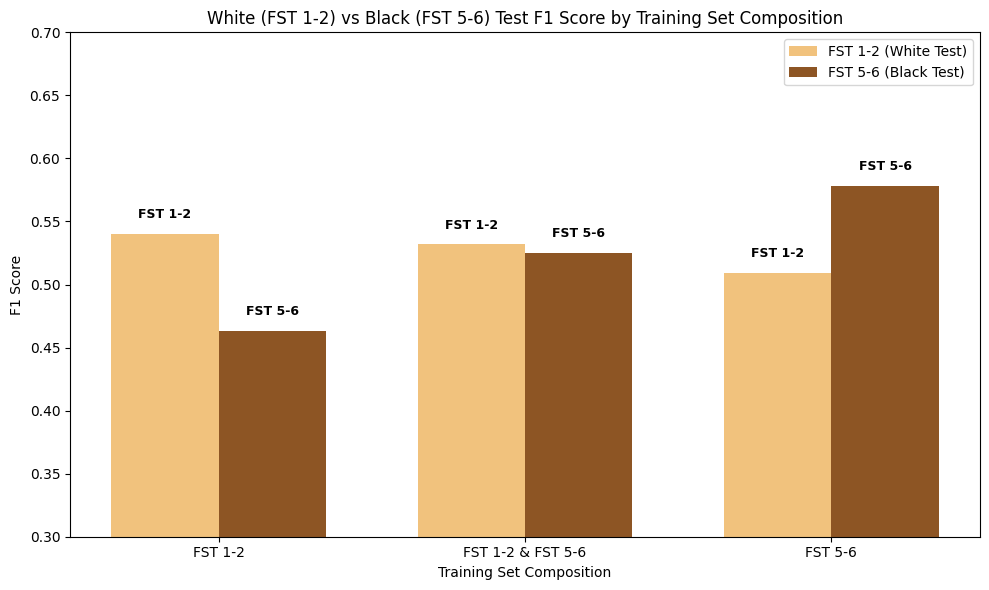

In [ ]:
# Prepare data for plotting
perc_black_labels = []
white_f1_scores = []
black_f1_scores = []

for perc_black, data in results.items():
    print(f"Results for perc_black = {perc_black}:")
    print(results[perc_black]['training_result'])

    perc_black_labels.append(perc_black)
    white_f1_scores.append(results[perc_black]['training_result'][0])
    black_f1_scores.append(results[perc_black]['training_result'][1])

tick_labels = ['FST 1-2', 'FST 1-2 & FST 5-6', 'FST 5-6']
# Define colors for racial groups
fst_white_skin_color = '#f1c27d'  # (FST 1-2)
fst_black_skin_color = '#8d5524'  #  (FST 5-6)

# Bar plot settings
bar_width = 0.35
x = range(len(perc_black_labels))

# Make the plots (they will be bars)
plt.figure(figsize=(10, 6))
white_bars = plt.bar(x, white_f1_scores, width=bar_width, label='FST 1-2 (White Test)', color=fst_white_skin_color)
black_bars = plt.bar([i + bar_width for i in x], black_f1_scores, width=bar_width, label='FST 5-6 (Black Test)', color=fst_black_skin_color)

# Add FST labels above each bar
for w_bar, b_bar in zip(white_bars, black_bars):
    plt.text(w_bar.get_x() + w_bar.get_width() / 2, w_bar.get_height() + 0.01, 'FST 1-2',
             ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')
    plt.text(b_bar.get_x() + b_bar.get_width() / 2, b_bar.get_height() + 0.01, 'FST 5-6',
             ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# Labels and title
plt.xlabel('Training Set Composition')
plt.ylabel('F1 Score')
plt.title('White (FST 1-2) vs Black (FST 5-6) Test F1 Score by Training Set Composition')
plt.xticks([i + bar_width / 2 for i in x], tick_labels)
plt.ylim(0.3, 0.7)
plt.legend()

plt.tight_layout()
plt.show()


## <font color='red'>Third Round of Discussion</font>

In this round, we focus on raising questions based on the results to better understand the model's behavior, potential pitfalls, and opportunities for improvement.

### Key Questions about the performance

- How does the **model's performance differ** across the various training configurations?
- Does the distribution of **skin tones in the training data affect performance** on specific subgroups?
- Is the **balanced dataset truly the most effective** in promoting fairness and generalization?

### Points to Reflect On

- **What might have caused** any observed performance gaps? Are there other factors beyond the racial group?
- Could the model be **overfitting** to certain features or groups?
- Are there visual or **diagnostic challenges** unique to specific skin tones?
- Was the **data augmentation strategy sufficient** to promote generalization?

### And now, what? Next Steps to Consider

- What steps can we take **to make the model more robust and fair**?
- Could **advanced augmentation or synthetic data** generation help address underrepresentation?

This use case, notebook, and discussions aim to awake interest and awareness about classification in medical imaging with sensitive groups. Sometimes naive or not that careful approaches may lead to gaps in performance and worsen the diagnostic power on specific subgroups. We hope the


